## Finding Gaussian Approximation for Woods-Saxon Potential

Setup: ignoring runtime warnings for large/complicated curvefit operations

In [1]:
import warnings
warnings.filterwarnings("ignore")

Importing libraries and defining global constants

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import sympy

DIFFUSIVITY = 0.6 # Diffusivity, may want to check the vaidity of this paticular number
r_0 = 1.2 # In fm, may want to chose a better value for small nuclei
A_C = 10 # The number of nucleons in the core
TOT_ANG_MOMENTUM = 0.5 # Total angular momentum
ORB_ANG_MOMENTUM = 1 # Orbital angular momentum

BETA_INITIAL_GUESS = 0.05 # In [fm]^-2
INITAL_C_GUESS = 0.01
V_LS = - 21.0
r, a, j, l, R0, V0, Vls = sympy.symbols('r a j l R0 V0 Vls')

We now define the potentials for the expansion of N Gaussians for N = 1, 2, 5, 12

In [3]:
def generate_beta_values(num_gaussians, r_1=0.49, a=2):
    betas = []
    for i in range(num_gaussians):
        r_n = r_1 * a**(i-1)
        betas.append(1/(r_n**2))
        
    return betas

def one_gaussian_potential(r, c_1, orb_ang_moment=ORB_ANG_MOMENTUM):
    """
    Defines our Gaussian potential as a sum of 1 different Gaussians of the form V_0 *(c_i *e^(beta_i*r^2)), for a set
    of c_i, beta_i.
    Input
    r : 1D array
    c : float
    beta : float
    """
    betas = generate_beta_values(1)
    V_0 = -11.39 * (-1)**orb_ang_moment - 51.13 # Defines V_0 for odd and even l states
    return V_0 * (c_1 * np.exp(-betas[0] * r**2))

def two_gaussian_potential(r, c_1, c_2, orb_ang_moment=ORB_ANG_MOMENTUM):
    """
    Defines our Gaussian potential as a sum of 2 different Gaussians of the form V_0 *(c_i *e^(beta_i*r^2)), for a set
    of c_i, beta_i.
    Input
    r : 1D array
    c : float
    beta : float
    """
    betas = generate_beta_values(2)
    V_0 = -11.39 * (-1)**orb_ang_moment - 51.13 # Defines V_0 for odd and even l states
    return V_0 * (c_1 * np.exp(-betas[0] * r**2) + c_2 * np.exp(-betas[1] * r**2))

def five_gaussian_potential(r, c_1, c_2, c_3, c_4, c_5, orb_ang_moment=ORB_ANG_MOMENTUM):
    """
    Defines our Gaussian potential as a sum of 5 different Gaussians of the form V_0 *(c_i *e^(beta_i*r^2)), for a set
    of c_i, beta_i.
    Input
    r : 1D array
    c : float
    beta : float
    """
    betas = generate_beta_values(5)
    V_0 = -11.39 * (-1)**orb_ang_moment - 51.13 # Defines V_0 for odd and even l states
    return (V_0) * (c_1 * np.exp(-betas[0] * r**2) + c_2 * np.exp(-betas[1]* r**2) + c_3 * np.exp(
        -betas[2] * r**2) + c_4 * np.exp(-betas[3]* r**2) + c_5 * np.exp(-betas[4] * r**2))

def twelve_gaussian_potential(r, c_1, c_2, c_3, c_4, c_5, c_6, c_7, c_8, c_9, c_10, c_11, c_12, orb_ang_moment=ORB_ANG_MOMENTUM):
    """
    Defines our Gaussian potential as a sum of 12 different Gaussians of the form V_0 *(c_i *e^(beta_i*r^2)), for a set
    of c_i, beta_i.
    Input
    r : 1D array
    c : float
    beta : float
    """
    betas = generate_beta_values(12)
    V_0 = -11.39 * (-1)**orb_ang_moment - 51.13 # Defines V_0 for odd and even l states
    return (V_0) * (c_1 * np.exp(-betas[0] * r**2) + c_2 * np.exp(-betas[1] * r**2) + c_3 * np.exp(
        -betas[2] * r**2) + c_4 * np.exp(-betas[3] * r**2) + c_5 * np.exp(-betas[4] * r**2) + c_6 * np.exp(
        -betas[5] * r**2) + c_7 * np.exp(-betas[6] * r**2) + c_8 * np.exp(-betas[7] * r**2) + c_9 * np.exp(
        -betas[8] * r**2) + c_10 * np.exp(-betas[9] * r**2) + c_11 * np.exp(-betas[10] * r**2) + c_12 * np.exp(-betas[11] * r**2))
    

We now use sympy to verify an algebraic expresion for our potential including spin orbit coupling

In [4]:
def finding_full_woods_saxon_potential(r, a, V0, Vls, R0, j, l):
    """
    Gets an algebraic expression to represent the full Woods-Saxon potential.
    r, a, V0, Vls, R0, j, & l are sympy symbols
    """
    woods_saxon_function = 1 / (1 + sympy.exp(((r - R0) / a)))
    woods_saxon_derivative = sympy.diff(woods_saxon_function, r)

    woods_saxon_term = V0 * woods_saxon_function
    l_dot_s = (( j * (j + 1)) - (l * (l + 1))- (3 / 4)) / 2
    spin_orbit_term = Vls * l_dot_s * (1 / r) * woods_saxon_derivative

    return woods_saxon_term + spin_orbit_term

print(finding_full_woods_saxon_potential(r, a, V0, Vls, R0, j, l))

V0/(exp((-R0 + r)/a) + 1) - Vls*(j*(j + 1)/2 - l*(l + 1)/2 - 0.375)*exp((-R0 + r)/a)/(a*r*(exp((-R0 + r)/a) + 1)**2)


We now have an algebraic expresion for our complete Woods-Saxon potential. We now want to evaluate this numerically in order to use in the curve_fit function for our Gaussian parameters

In [5]:
def complete_potential(radius, tot_ang_moment=TOT_ANG_MOMENTUM, orb_ang_moment=ORB_ANG_MOMENTUM, V_ls=V_LS, diffusivity=DIFFUSIVITY, r_0=r_0, num_core_nucleons=A_C):
    """
    Numerically evaluates the complete Woods-Saxon potential (including the spin-orbit interaction) for our system
    Input
    radius : float [fm]
    """
    V_0 = -11.39 * (-1)**orb_ang_moment - 51.13 # Defines V_0 for odd and even l states
    R_0 = r_0 * num_core_nucleons**(1/3)
    
    central_potential_term = V_0 / (np.exp((radius - R_0) / diffusivity) + 1)
    spin_orbit_coupling_term = ((tot_ang_moment * (tot_ang_moment + 1)) / 2) - ((orb_ang_moment * (
        orb_ang_moment + 1)) / 2) - 0.375
    woods_saxon_derivative = np.exp((radius - R_0) / diffusivity) / (diffusivity * radius * (
        np.exp((radius - R_0) / diffusivity) + 1)**2)

    return central_potential_term - V_ls * spin_orbit_coupling_term * woods_saxon_derivative

def no_spin_orbit_potential(radius, tot_ang_moment=TOT_ANG_MOMENTUM, orb_ang_moment=ORB_ANG_MOMENTUM, V_ls=V_LS, diffusivity=DIFFUSIVITY, r_0=r_0, num_core_nucleons=A_C):
    """
    Numerically evaluates the complete Woods-Saxon potential (including the spin-orbit interaction) for our system
    Input
    radius : float [fm]
    """
    V_0 = -11.39 * (-1)**orb_ang_moment - 51.13 # Defines V_0 for odd and even l states
    R_0 = r_0 * num_core_nucleons**(1/3)
    
    central_potential_term = V_0 / (np.exp((radius - R_0) / diffusivity) + 1)

    return central_potential_term

Perform the curve fit to find parameters for our Gaussian estimates

In [6]:
r_values = np.linspace(0.0001, 8, 1000000)

two_gaussian_curve_fit_result, two_gaussian_covariances = curve_fit(
        two_gaussian_potential, r_values, no_spin_orbit_potential(r_values), [
            0.292, 0.559], maxfev=100000)
print(two_gaussian_curve_fit_result)

#note: diagonal elements of the covariance matrix will give the variance on each fit parameter
two_gaussian_errors = np.sqrt(np.diag(two_gaussian_covariances))
print(two_gaussian_errors)

[-1.79426004  2.51748969]
[0.00654634 0.00462824]


In [7]:
r_values = np.linspace(0.0001, 8, 1000)

twelve_gaussian_curve_fit_result, twelve_gaussian_covariances = curve_fit(
        twelve_gaussian_potential, r_values, no_spin_orbit_potential(r_values), [
        0.272822, -1.30687, 3.3052, -5.6565,
        6.5652, -3.36817, -2.43681, 2.63772,
        0.718998, 0.234668, 0.0186034, 0.00107583], maxfev=10000000)
print(twelve_gaussian_curve_fit_result)

#note: diagonal elements of the covariance matrix will give the variance on each fit parameter
twelve_gaussian_errors = np.sqrt(np.diag(twelve_gaussian_covariances))
print(twelve_gaussian_errors)

[-1.97277522e-02  6.34268934e-02 -6.86301895e-02 -1.15052665e+00
  2.77391563e+01 -1.41044525e+03  5.79603259e+04 -7.82319509e+05
  2.31327753e+06 -7.80776617e+03 -5.34738714e+03 -1.57437833e+06]
[1.45856295e-03 2.01909835e-03 2.23270906e-03 5.89521410e-03
            nan            nan            nan            nan
            nan 1.74702903e+02 1.13436646e+02            nan]


Plotting the fit results for multiple numbers of Gaussians, including a log plot to investigate the strength of the fit in detail

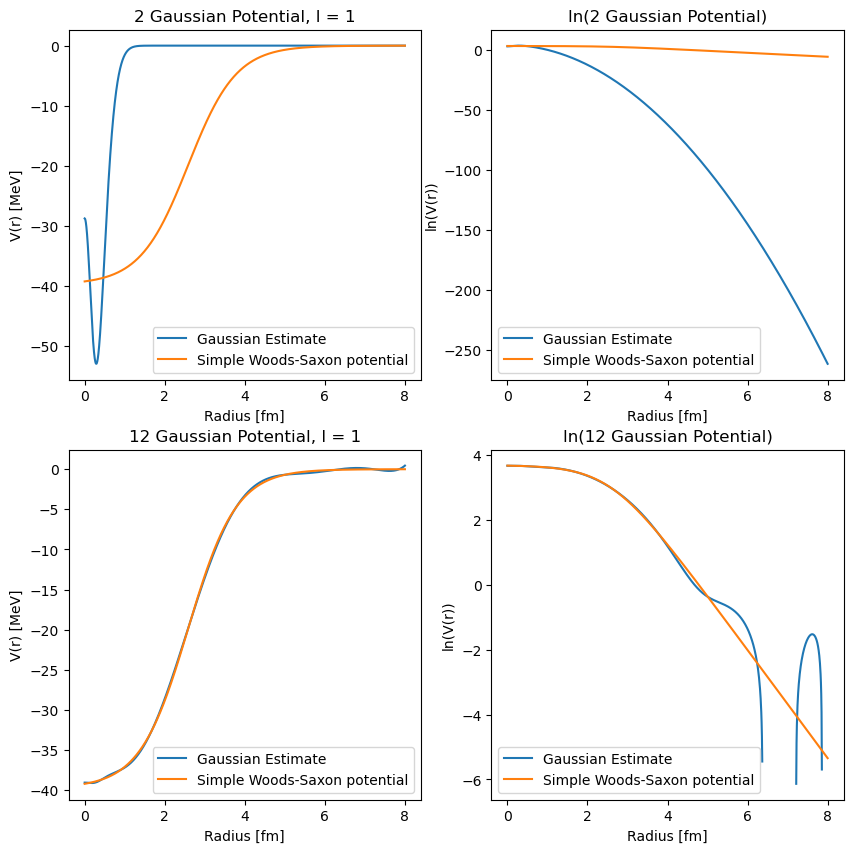

In [15]:
fig = plt.figure(figsize=(10, 10))
spec = fig.add_gridspec(ncols=2, nrows=2)
ax_1 = fig.add_subplot(spec[0, 0])
ax_2 = fig.add_subplot(spec[0, 1])
ax_3 = fig.add_subplot(spec[1, 0])
ax_4 = fig.add_subplot(spec[1, 1])

r_plot = np.linspace(0, 8, 100000)

g2_C_1, g2_C_2, = two_gaussian_curve_fit_result
g12_C_1, g12_C_2, g12_C_3, g12_C_4, g12_C_5, g12_C_6, g12_C_7, g12_C_8, g12_C_9, g12_C_10, g12_C_11, g12_C_12= twelve_gaussian_curve_fit_result

ax_1.set_title('2 Gaussian Potential, l = {0}'.format(ORB_ANG_MOMENTUM))
ax_1.set_xlabel('Radius [fm]')
ax_1.set_ylabel('V(r) [MeV]')
ax_1.plot(r_plot, two_gaussian_potential(r_plot, g2_C_1, g2_C_2), label=f'Gaussian Estimate')
ax_1.plot(r_values, no_spin_orbit_potential(r_values), label='Simple Woods-Saxon potential')
ax_1.legend(loc='lower right')

ax_2.set_title('ln(2 Gaussian Potential)')
ax_2.set_xlabel('Radius [fm]')
ax_2.set_ylabel('ln(V(r))')
ax_2.plot(r_values, np.log(-two_gaussian_potential(r_values, g2_C_1, g2_C_2)), label=f'Gaussian Estimate')
ax_2.plot(r_values, np.log(-no_spin_orbit_potential(r_values)), label='Simple Woods-Saxon potential')
ax_2.legend(loc='lower left')

ax_3.set_title('12 Gaussian Potential, l = {0}'.format(ORB_ANG_MOMENTUM))
ax_3.set_xlabel('Radius [fm]')
ax_3.set_ylabel('V(r) [MeV]')
ax_3.plot(r_plot, twelve_gaussian_potential(r_plot, g12_C_1, g12_C_2, g12_C_3, g12_C_4,
                                       g12_C_5,  g12_C_6,  g12_C_7, g12_C_8,
                                       g12_C_9, g12_C_10,  g12_C_11, g12_C_12,), label=f'Gaussian Estimate')
ax_3.plot(r_values, no_spin_orbit_potential(r_values), label='Simple Woods-Saxon potential')
ax_3.legend(loc='lower right')

ax_4.set_title('ln(12 Gaussian Potential)')
ax_4.set_xlabel('Radius [fm]')
ax_4.set_ylabel('ln(V(r))')
ax_4.plot(r_values, np.log(-twelve_gaussian_potential(r_values, g12_C_1, g12_C_2, g12_C_3, g12_C_4,
                                       g12_C_5, g12_C_6, g12_C_7, g12_C_8, 
                                       g12_C_9, g12_C_10, g12_C_11, g12_C_12)), label=f'Gaussian Estimate')
ax_4.plot(r_values, np.log(-no_spin_orbit_potential(r_values)), label='Simple Woods-Saxon potential')
ax_4.legend(loc='lower left')

plt.savefig('potentials_plot.png', dpi=300)
plt.show()

ok now i will differentiate these gaussians in order to build up the full woods-saxon potential

In [16]:
g2_potential = two_gaussian_potential(r_values, g2_C_1, g2_C_2)

g12_potential = twelve_gaussian_potential(r_values, g12_C_1, g12_C_2, g12_C_3, g12_C_4,
                                       g12_C_5, g12_C_6, g12_C_7, g12_C_8,
                                       g12_C_9, g12_C_10, g12_C_11, g12_C_12)

def build_full_potential(radius, basic_gaussian_potential, tot_ang_moment=TOT_ANG_MOMENTUM, orb_ang_moment=ORB_ANG_MOMENTUM, V_ls=V_LS):
    woods_saxon_derivative = np.diff(basic_gaussian_potential)
    
    spin_orbit_coupling_term = ((tot_ang_moment * (tot_ang_moment + 1)) / 2) - ((orb_ang_moment * (
        orb_ang_moment + 1)) / 2) - 0.375
    
    return basic_gaussian_potential[:-1] - (V_ls * spin_orbit_coupling_term * (1/radius) * woods_saxon_derivative)
    
two_gaussian_corrected_potential = build_full_potential(r_values[:-1], g2_potential)
twelve_gaussian_corrected_potential = build_full_potential(r_values[:-1], g12_potential)


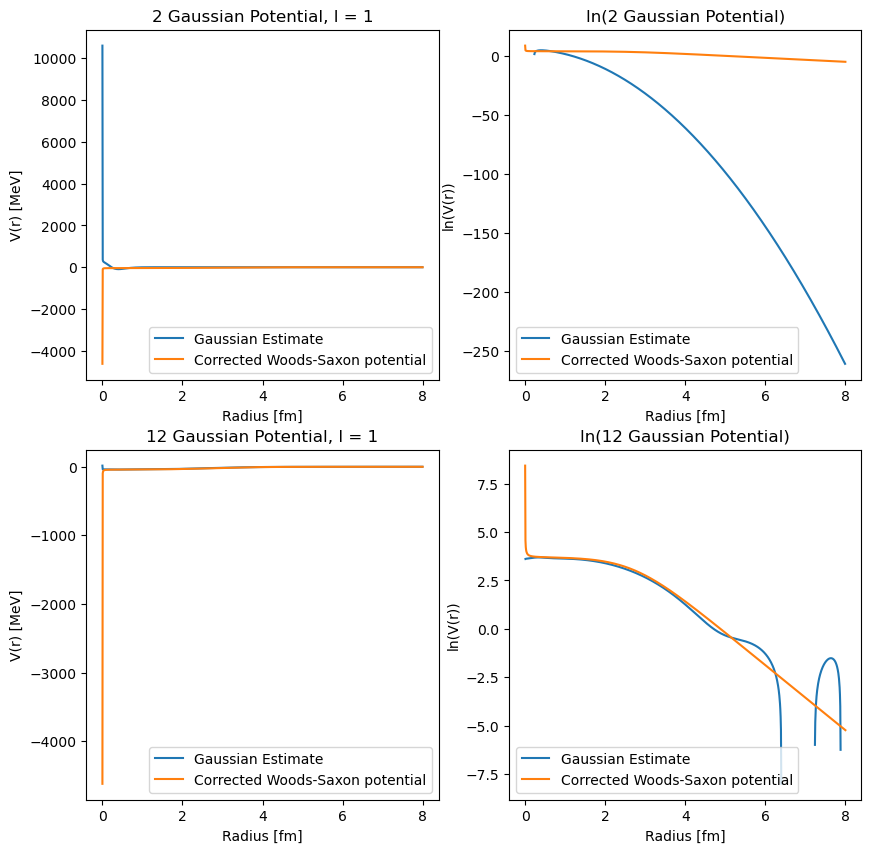

In [17]:
fig = plt.figure(figsize=(10, 10))
spec = fig.add_gridspec(ncols=2, nrows=2)
ax_1 = fig.add_subplot(spec[0, 0])
ax_2 = fig.add_subplot(spec[0, 1])
ax_3 = fig.add_subplot(spec[1, 0])
ax_4 = fig.add_subplot(spec[1, 1])

ax_1.set_title('2 Gaussian Potential, l = {0}'.format(ORB_ANG_MOMENTUM))
ax_1.set_xlabel('Radius [fm]')
ax_1.set_ylabel('V(r) [MeV]')
ax_1.plot(r_values[:-1], two_gaussian_corrected_potential, label=f'Gaussian Estimate')
ax_1.plot(r_values, complete_potential(r_values), label='Corrected Woods-Saxon potential')
ax_1.legend(loc='lower right')

ax_2.set_title('ln(2 Gaussian Potential)')
ax_2.set_xlabel('Radius [fm]')
ax_2.set_ylabel('ln(V(r))')
ax_2.plot(r_values[:-1], np.log(-two_gaussian_corrected_potential), label=f'Gaussian Estimate')
ax_2.plot(r_values, np.log(-complete_potential(r_values)), label='Corrected Woods-Saxon potential')
ax_2.legend(loc='lower left')

ax_3.set_title('12 Gaussian Potential, l = {0}'.format(ORB_ANG_MOMENTUM))
ax_3.set_xlabel('Radius [fm]')
ax_3.set_ylabel('V(r) [MeV]')
ax_3.plot(r_values[:-1], twelve_gaussian_corrected_potential, label=f'Gaussian Estimate')
ax_3.plot(r_values, complete_potential(r_values), label='Corrected Woods-Saxon potential')
ax_3.legend(loc='lower right')

ax_4.set_title('ln(12 Gaussian Potential)')
ax_4.set_xlabel('Radius [fm]')
ax_4.set_ylabel('ln(V(r))')
ax_4.plot(r_values[:-1], np.log(-twelve_gaussian_corrected_potential), label=f'Gaussian Estimate')
ax_4.plot(r_values, np.log(-complete_potential(r_values)), label='Corrected Woods-Saxon potential')
ax_4.legend(loc='lower left')

plt.savefig('potentials_plot.png', dpi=300)
plt.show()
